# Creating Customer Segments

Analysis of a dataset containing annual spending amounts, aiming to identify the internal structure and understand the variation in the different types of customers that a wholesale distributor interacts with.

Part of the Udacity Machine Learning Engineer Nanodegree program.

In [1]:
# Import libraries: NumPy, pandas, matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

# Use float division by default
from __future__ import division
# Use print() instead of the print statement
from __future__ import print_function

# Tell iPython to include plots inline in the notebook
%matplotlib inline

# Set plot style
plt.style.use('bmh')
mpl.rcParams['font.family'] = 'Ubuntu'
mpl.rcParams['font.size'] = 12
mpl.rcParams['figure.figsize'] = [10, 7]

# Read dataset
data = pd.read_csv("wholesale-customers.csv")
print("Dataset has {} rows, {} columns".format(*data.shape))
print(data.head())  # print the first 5 rows

Dataset has 440 rows, 6 columns
   Fresh  Milk  Grocery  Frozen  Detergents_Paper  Delicatessen
0  12669  9656     7561     214              2674          1338
1   7057  9810     9568    1762              3293          1776
2   6353  8808     7684    2405              3516          7844
3  13265  1196     4221    6404               507          1788
4  22615  5410     7198    3915              1777          5185


## Feature Transformation

**1)** In this section, you will be using PCA and ICA to start to understand the structure of the data. Before doing any computations, what do you think will show up in your computations? List one or two ideas for what might show up as the first PCA dimensions, or what type of vectors will show up as ICA dimensions.

**Answer:** ICA seeks to transform a set of mixed signals to a set of source signals. (For example, in the case of the "Cocktail party problem", the source signals are different speakers/bands/noise sources, and the mixed signals are the sounds recorded by different microphones.)
Since the mixed signals here are the orders of 
different stores, I think the source signals that ICA will find are going to represent different store archetypes.

PCA transforms the data into a new feature space too, but instead of looking for source signals, it just maximizes the captured variance for each of the new dimensions.
While this can be very useful for dimensionality reduction and finding out how the original dimensions are correlated, the new dimensions don't have deeper meanings, they are just linear combinations of the original dimensions.

### PCA

        Fresh    Milk  Grocery  Frozen  Detergents_Paper  Delicatessen
0.460  -0.977  -0.121   -0.062  -0.152             0.007        -0.068
0.405  -0.111   0.516    0.765  -0.019             0.365         0.057
0.070  -0.179   0.510   -0.276   0.714            -0.204         0.283
0.044  -0.042  -0.646    0.375   0.646             0.149        -0.020
0.015   0.016   0.203   -0.160   0.220             0.208        -0.917
0.006  -0.016   0.033    0.411  -0.013            -0.871        -0.265


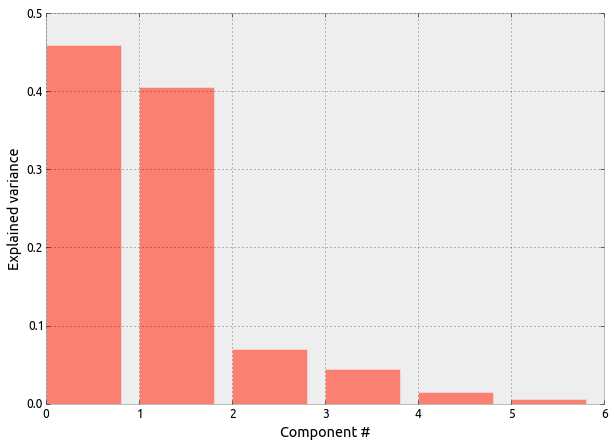

In [2]:
# Center the data by subtracting the mean from each column
scaled_data = data - np.mean(data)

# Apply PCA with the same number of dimensions as variables in the dataset
from sklearn.decomposition import PCA
pca = PCA(data.shape[1]).fit(scaled_data)

# Print the components and the amount of variance in the data contained in each dimension
components = pd.DataFrame(data=pca.components_, columns=data.columns.get_values(), index=pca.explained_variance_ratio_)

pd.set_option('float_format', '{:7,.3f}'.format)
print(components)

plt.bar(range(len(pca.explained_variance_ratio_)), pca.explained_variance_ratio_, color='salmon')
plt.xlabel('Component #')
plt.ylabel('Explained variance')

**2)** How quickly does the variance drop off by dimension? If you were to use PCA on this dataset, how many dimensions would you choose for your analysis? Why?

**Answer:** The variance drops off very quickly after the first two dimensions, therefore I would choose those two because the other components are likely to be noise. Another benefit is that it's easy to plot 2D data.

**3)** What do the dimensions seem to represent? How can you use this information?

**Answer:** The first new dimension is mostly correlated with the Fresh category of the original data.

The second new dimension is roughly a combination of the following original categories: Grocery, Milk, and Detergents_Paper.

The data will be transformed into a 2D feature space with these two dimensions, and knowing what the dimensions represent will make it easier to understand the differences between the data points on the chart which will show the transformed data.

How the original features are combined into the new features is also indicative of the correlations between the original features. For example, it can be seen that Milk and Detergents_Paper are correlated.

### ICA

In [3]:
# Fit an ICA model to the data
from sklearn.decomposition import FastICA
ica = FastICA(data.shape[1], random_state=1).fit(scaled_data)

# Print the independent components
components = pd.DataFrame(data=ica.components_, columns=data.columns.get_values())
# The components are multiplied by a constant so that they are easier to read
# This doesn't change the interpretation, as the magnitudes are interpreted relatively
# and the signs stay the same
print(components * 1e7)

    Fresh    Milk  Grocery   Frozen  Detergents_Paper  Delicatessen
0  39.760  -8.588   -6.275   -6.773            20.670       -10.423
1   2.107 -18.798   64.228    4.114            -8.050       -14.582
2   1.530  98.484  -58.043   -3.652            32.936       -60.610
3   3.865   2.194    6.001    5.221            -5.087      -180.923
4  -2.993  22.993  120.639  -14.624          -282.089       -57.278
5   8.652   1.405   -7.737 -111.462             5.546        59.521


**4)** For each vector in the ICA decomposition, write a sentence or two explaining what sort of object or property it corresponds to. What could these components be used for?

**Answer:** I think that the vectors here correspond to independent effects the categories have on each other; for example:

0. Stores that buy more Fresh items usually buy more Detergents_Paper too, at the expense of the other categories. (The latter effect can be explained by the fact that stores have limited shelf space.)
2. Buying more Milk is associated with buying less Grocery and Delicatessen. (based on component 2)
4. Buying more Detergents_Paper is associated with buying less Grocery. (component 4)
5. Buying more Delicatessen is associated with buying less Frozen food. (component 5)

Note that the effects' "inverse" is also true, as the signs are arbitrary. (e.g. Reversing the last interpretation, buying more Frozen items is associated with buying less Deli food.)

## Clustering

In this section you will choose either K-Means clustering or Gaussian Mixed Models clustering, which implements expectation-maximization. Then you will sample elements from the clusters to understand their significance.

### Choose a Cluster Type

**5)** What are the advantages of using K-Means clustering or Gaussian Mixture Models?

**Answer:** K-Means is a hard-clustering algorithm, meaning each data point is assigned to a single class. It does this by calculating L2 distances between the data point and the cluster centers, and then assigning the data point to the nearest cluster center.

Because of this, the borders between the clusters appear as straight lines, equidistant from the cluster centers.

In contrast, GMM works by fitting Gaussian distributions to the data (more precisely, to the clusters). This makes it a soft-clustering algorithm, because each of the data points is affilated with all of the  clusters, to varying degrees.

Using a GMM with two clusters seems to be the superior choice here, because the data as visualized only has a single clearly visible cluster (the other "cluster" that the GMM will find should contain the outliers), and K-Means can't handle that well (as the borders have to be straight lines between the clusters).

**6)** Below is some starter code to help you visualize some cluster data. The visualization is based on [this demo](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_digits.html) from the sklearn documentation.

In [4]:
# Import clustering modules
from sklearn.cluster import KMeans
from sklearn.mixture import GMM

In [5]:
# First we reduce the data to two dimensions using PCA to capture variation
pca.n_components = 2
reduced_data = pca.fit_transform(data)
# Uncomment this line to log transform the data
#reduced_data = np.log(reduced_data + abs(np.min(reduced_data, axis=0)) + 1)

np.set_printoptions(suppress=True)
print(reduced_data[:10])  # print upto 10 elements

[[  -650.02212207   1585.51909007]
 [  4426.80497937   4042.45150884]
 [  4841.9987068    2578.762176  ]
 [  -990.34643689  -6279.80599663]
 [-10657.99873116  -2159.72581518]
 [  2765.96159271   -959.87072713]
 [   715.55089221  -2013.00226567]
 [  4474.58366697   1429.49697204]
 [  6712.09539718  -2205.90915598]
 [  4823.63435407  13480.55920489]]


In [6]:
# Instantiate the clustering algorithm and fit it to the reduced data for visualization
gmm_2 = GMM(2).fit(reduced_data)
# Two clusters:
#   * One for the actual cluster of smaller shops
#   * One for the outliers, the big stores

print(gmm_2)

# Also try a few other hyperparameter/algorithm combinations
gmm_3 = GMM(3).fit(reduced_data)
kmeans_2 = KMeans(2).fit(reduced_data)
kmeans_3 = KMeans(3).fit(reduced_data)

GMM(covariance_type='diag', init_params='wmc', min_covar=0.001,
  n_components=2, n_init=1, n_iter=100, params='wmc', random_state=None,
  thresh=None, tol=0.001, verbose=0)


In [7]:
# Plot the decision boundary by building a mesh grid to populate a graph.
def create_mesh(clusters):
    x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
    y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
    hx = (x_max - x_min) / 1000
    hy = (y_max - y_min) / 1000
    xx, yy = np.meshgrid(np.arange(x_min, x_max, hx), np.arange(y_min, y_max, hy))
    
    # Obtain labels for each point in mesh. Use last trained model.
    Z = clusters.predict(np.c_[xx.ravel(), yy.ravel()])
    
    return Z, xx, yy, x_min, x_max, y_min, y_max

In [8]:
# Find the centroids for KMeans or the cluster means for GMM 
def get_centroids(clusters):
    try:
        centroids = clusters.means_
    except AttributeError:
        centroids = clusters.cluster_centers_
    
    return centroids

In [9]:
from math import floor, ceil, sqrt

# Put the result into a color plot
def plot_result(Z, xx, yy, x_min, x_max, y_min, y_max, centroids, n_plots):
    columns = int(ceil(sqrt(n_plots)))
    rows = int(floor(n_plots / columns))
    subplt = figure.add_subplot(str(rows) + str(columns) + str(plot_result.i_plot))
    plot_result.i_plot += 1
    
    Z = Z.reshape(xx.shape)

    subplt.imshow(Z, interpolation='nearest',
               extent=(xx.min(), xx.max(), yy.min(), yy.max()),
               cmap=plt.cm.Pastel1,
               aspect='auto', origin='lower')

    plot_scale = max(1 / (rows * columns), 1 / 2)
    subplt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2*plot_scale)
    subplt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=169, linewidths=3*plot_scale,
                color='r', zorder=10)
    
    if rows == columns == 1:
        plt.title('Clustering on the wholesale grocery dataset (PCA-reduced data)\n'
                  'Centroids are marked with red cross')
        plt.xlabel('.98 Fresh, .15 Frozen, .12 Milk')
        plt.ylabel('.77 Grocery, .51 Milk, .36 Detergents_Paper')
        
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.xticks(())
    plt.yticks(())

/usr/local/lib/python2.7/dist-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


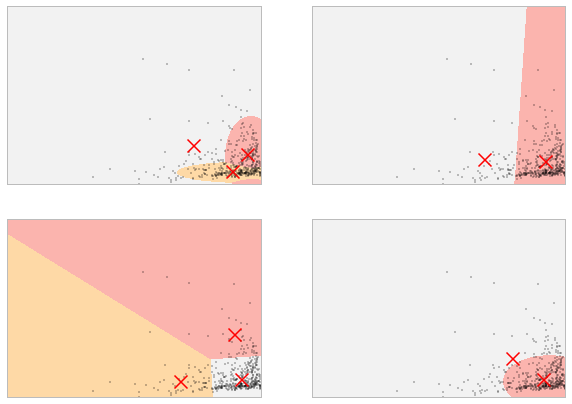

In [10]:
plot_result.i_plot = 0
figure = plt.figure()

plot_result(*create_mesh(gmm_2), centroids=get_centroids(gmm_2), n_plots=4)
plot_result(*create_mesh(gmm_3), centroids=get_centroids(gmm_3), n_plots=4)
plot_result(*create_mesh(kmeans_2), centroids=get_centroids(kmeans_2), n_plots=4)
plot_result(*create_mesh(kmeans_3), centroids=get_centroids(kmeans_3), n_plots=4)

plt.show()

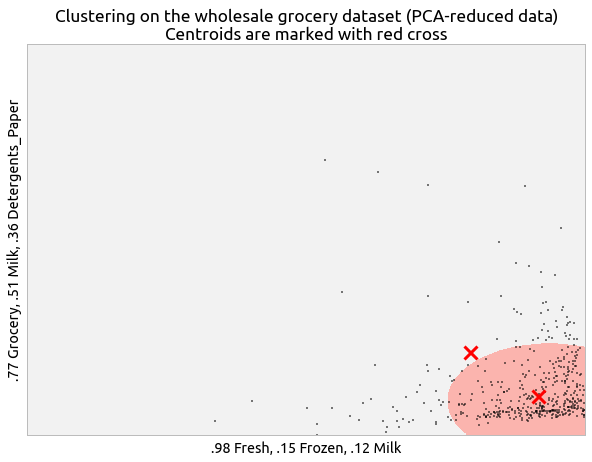

Centroids:
[[  3308.39301792  -3017.01739698]
 [-10810.23008886   9858.15532401]]


In [11]:
plot_result.i_plot = 0
figure = plt.figure()
centroids = get_centroids(gmm_2)
plot_result(*create_mesh(gmm_2), centroids=centroids, n_plots=1)
plt.show()
print('Centroids:')
print(centroids)

**7)** What are the central objects in each cluster? Describe them as customers.

In [12]:
original_centroid_features = pca.inverse_transform(centroids)

df_ocf = pd.DataFrame(data=original_centroid_features, columns=data.columns.get_values())
print(df_ocf)

       Fresh       Milk    Grocery    Frozen  Detergents_Paper  Delicatessen
0  9,103.254  3,839.157  5,440.847 2,624.339         1,802.562     1,127.344
1 21,466.437 12,191.151 16,154.152 4,534.450         6,406.921     2,823.794


**Answer:** 
* Bottom right cluster: a small, family-run shop
* Outliers: bigger supermarket

### Conclusions

** 8)** Which of these techniques did you feel gave you the most insight into the data?

**Answer:** I think that Pricipal Component Analysis was the most useful technique here, because it enabled the visualization of the data while keeping most of the variance.

It also helped with clustering, since the clusters could be visualized along with the data.

**9)** How would you use that technique to help the company design new experiments?

**Answer:** I would suggest splitting future experiments (A/B tests) into two separate experiments. The only difference between the two being that one of them should use data points from the first cluster, the other from the second cluster.

For example, if we wanted to test if the company can introduce midday delivery, we would have to assemble two groups (let's call them X and Y). X would contain randomly selected stores from the first cluster, and Y would contain randomly selected shops from the other cluster.

Then, we would split both X and Y into two subgroups; one subgroup would contain stores we've introduced midday delivery for, the other would be the control subgroup. (So we would have 2 control subgroups, and 2 experimental subgroups.)

After getting feedback from all subgroups, we would have separate results for the different clusters. This way, the feedback of the more active group couldn't wash out the responses of the other.

**10)** How would you use that data to help you predict future customer needs?

**Answer:** For example, if a new type of product was being trialed, it would be possible to roll it out to a few customers first. Then, the initial results could be used to create a regression model, which could predict how much the other customers will buy of the new product type.

This regression model could use the cluster assignments as an additional feature of the customers.